In [22]:
import logging

logging.disable(logging.WARNING)

import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

import os
import pickle
import re
from pprint import pprint

import pandas as pd
import plotly.express as px
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import spacy
from gensim import corpora
from gensim.models import CoherenceModel, LdaMulticore, Phrases
from gensim.models.phrases import Phraser
from gensim.utils import simple_preprocess
from IPython.core.interactiveshell import InteractiveShell
from nltk.corpus import stopwords
from pymongo import MongoClient
from wordcloud import WordCloud

InteractiveShell.ast_node_interactivity = "all"
pyLDAvis.enable_notebook()

In [2]:
client = MongoClient("localhost:27017")
db = client["wallstreetbets"]
submission_records = db.submission_records
df = pd.DataFrame(
    list(
        submission_records.find(
            {
                "is_self_post": True,
                "is_removed_by_author": False,
                "is_removed_by_moderator": False,
                "selftext": {"$exists": True, "$ne": ""},
            }
        )
    )
)
df.columns
df.shape

Index(['_id', 'id', 'author', 'author_deleted', 'body_emoji', 'created_utc',
       'distinguished', 'edited_utc', 'is_edited', 'is_locked', 'is_nsfw',
       'is_original_content', 'is_removed_by_author',
       'is_removed_by_moderator', 'is_self_post', 'is_stickied',
       'link_flair_text', 'num_comments', 'permalink', 'score', 'selftext',
       'title', 'title_emoji', 'upvote_ratio', 'url', 'mbti', 'toxicity',
       'roberta-sentiment', 'hate-speech', 'toxicity_ensemble'],
      dtype='object')

(16459, 30)

In [3]:
df = df[["selftext"]]
type(df)
df.head()

pandas.core.frame.DataFrame

,selftext
0,The CEO of NASDAQ pushed to halt trading “to g...
1,You guys are champs. GME... who would have tho...
2,Your daily trading discussion thread. Please k...
3,I still remember when I first joined and most ...
4,https://youtu.be/BtjhgcAMYU0


In [4]:
stop_words = stopwords.words("english")
stop_words.extend(
    [
        "stock",
        "in",
        "re",
        "this",
        "price",
        "company",
        "like",
        "get",
        "share",
        "would",
        "think",
        "all",
        "could",
        "make",
        "market",
        "one",
        "best",
        "short",
        "it",
        "the",
        "share",
        "also",
        "see",
        "here",
        "look",
    ]
)

# Remove url links
df["selftext_processed"] = df["selftext"].map(
    lambda x: re.sub(
        "http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", "", x
    )
)

# Remove punctuation
# df["selftext_processed"] = df["selftext_processed"].map(
#     lambda x: re.sub('[,\.!?"]', "", x)
# )

# Remove spaces > 1
df["selftext_processed"] = df["selftext_processed"].map(lambda x: re.sub(" +", " ", x))

# Convert to lowercase
df["selftext_processed"] = df["selftext_processed"].map(lambda x: x.lower())

# Remove new line characters
df["selftext_processed"] = df["selftext_processed"].map(lambda x: re.sub("\s+", " ", x))

# Remove distracting single quotes
df["selftext_processed"] = df["selftext_processed"].map(lambda x: re.sub("'", "", x))

# Remove multiple letter repeating words
# df["selftext_processed"] = df["selftext_processed"].map(
#     lambda x: re.sub(r"([a-z])\1{2,}[\s|\w]*", "", x)
# )

# # Convert to stems
# df["selftext_processed"] = df["selftext_processed"].map(
#     lambda x: " ".join(
#         [lemmatiser.lemmatize(w) for w in x.split(" ") if w not in stop_words]
#     )
# )

# # Remove stop words
# df["selftext_processed"] = df["selftext_processed"].map(
#     lambda x: " ".join([w for w in x.split(" ") if w not in stop_words])
# )

df.head()

<>:52: DeprecationWarning: invalid escape sequence \s
<>:52: DeprecationWarning: invalid escape sequence \s
/tmp/ipykernel_4128758/559361159.py:52: DeprecationWarning: invalid escape sequence \s
  df["selftext_processed"] = df["selftext_processed"].map(lambda x: re.sub('\s+', ' ', x))


,selftext,selftext_processed
0,The CEO of NASDAQ pushed to halt trading “to g...,the ceo of nasdaq pushed to halt trading “to g...
1,You guys are champs. GME... who would have tho...,you guys are champs. gme... who would have tho...
2,Your daily trading discussion thread. Please k...,your daily trading discussion thread. please k...
3,I still remember when I first joined and most ...,i still remember when i first joined and most ...
4,https://youtu.be/BtjhgcAMYU0,


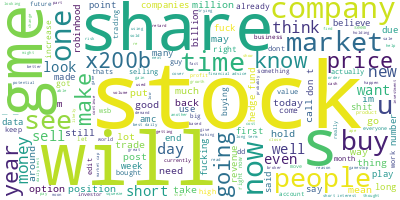

In [5]:
long_string = ",".join(list(df["selftext_processed"].values))
wordcloud = WordCloud(
    background_color="white", max_words=5000, contour_width=3, contour_color="steelblue"
)
_ = wordcloud.generate(long_string)
wordcloud.to_image()

In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield (simple_preprocess(str(sentence), deacc=True))


data = df["selftext_processed"].values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1][0][:30])

['the', 'ceo', 'of', 'nasdaq', 'pushed', 'to', 'halt', 'trading', 'to', 'give', 'investors', 'chance', 'to', 'recalibrate', 'their', 'positions', 'now', 'sec', 'is', 'investigating', 'brokers', 'are', 'disallowing', 'buying', 'more', 'calls', 'this', 'is', 'the', 'institutions']


In [7]:
# Build the bigram and trigram models
bigram = Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['the', 'ceo', 'of', 'nasdaq', 'pushed', 'to', 'halt', 'trading', 'to', 'give', 'investors', 'chance', 'to', 'recalibrate', 'their', 'positions', 'now', 'sec', 'is', 'investigating', 'brokers', 'are', 'disallowing', 'buying', 'more', 'calls', 'this', 'is', 'the', 'institutions', 'flat', 'out', 'admitting', 'they', 'will', 'change', 'the', 'rules', 'to', 'bail', 'out', 'the', 'rich', 'but', 'if', 'it', 'happens', 'to', 'us', 'we', 'get', 'well', 'shucks', 'you', 'should', 'have', 'known', 'investing', 'is', 'risky', 'have', 'you', 'tried', 'cutting', 'out', 'avocados', 'and', 'coffee', 'maybe', 'doing', 'uber', 'on', 'the', 'side', 'we', 'may', 'have', 'collectively', 'driven', 'up', 'enough', 'sentiment', 'in', 'wall_street', 'to', 'make', 'other', 'big', 'players', 'go', 'long', 'on', 'gme', 'with', 'us', 'we', 'do', 'not', 'have', 'the', 'money', 'to', 'move', 'the', 'stock', 'as', 'much', 'as', 'it', 'did', 'alone', 'we', 'didn', 'hurt', 'wall_street', 'as', 'whole', 'just', 'few', 

In [8]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [
        [word for word in simple_preprocess(str(doc)) if word not in stop_words]
        for doc in texts
    ]


def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]


def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]


def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append(
            [token.lemma_ for token in doc if token.pos_ in allowed_postags]
        )
    return texts_out

In [9]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(
    data_words_bigrams, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]
)

print(data_lemmatized[:1])

[['push', 'halt', 'trading', 'give', 'investor', 'chance', 'recalibrate', 'position', 'investigate', 'broker', 'disallow', 'buying', 'call', 'institution', 'flat', 'admit', 'change', 'rule', 'bail', 'rich', 'happen', 'well', 'shuck', 'know', 'invest', 'risky', 'try', 'cutting', 'avocado', 'coffee', 'maybe', 'uber', 'side', 'collectively', 'drive', 'enough', 'sentiment', 'wall_street', 'big', 'player', 'go', 'long', 'gme', 'money', 'move', 'much', 'alone', 'hurt', 'whole', 'fund', 'go', 'other', 'go', 'profit', 'short', 'medium', 'want', 'pin', 'blame', 'crystal', 'clear', 'rig', 'game', 'time', 'build', 'new', 'exchange', 'arbitrarily', 'change', 'rule', 'version', 'maybe', 'repurpose', 'trade', 'government', 'intervention', 'know', 'exactly', 'yet', 'broad', 'next', 'step', 'exit', 'current', 'financial', 'system', 'build', 'new']]


In [10]:
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


In [13]:
num_topics = 4

lda_model = LdaMulticore(
    corpus=corpus,
    id2word=id2word,
    num_topics=num_topics,
    chunksize=100,
    passes=10,
    per_word_topics=True,
)

pprint(lda_model.print_topics())

doc_lda = lda_model[corpus]

[(0,
  '0.017*"go" + 0.013*"do" + 0.012*"buy" + 0.011*"gme" + 0.011*"know" + '
  '0.010*"money" + 0.010*"people" + 0.009*"hold" + 0.009*"m" + 0.008*"get"'),
 (1,
  '0.028*"share" + 0.014*"gme" + 0.011*"buy" + 0.010*"trade" + 0.010*"sell" + '
  '0.009*"robinhood" + 0.009*"short" + 0.008*"position" + 0.008*"account" + '
  '0.007*"broker"'),
 (2,
  '0.011*"go" + 0.010*"high" + 0.009*"call" + 0.008*"share" + 0.007*"day" + '
  '0.007*"week" + 0.007*"option" + 0.007*"buy" + 0.007*"low" + 0.006*"time"'),
 (3,
  '0.011*"year" + 0.007*"revenue" + 0.006*"company" + 0.006*"growth" + '
  '0.005*"use" + 0.004*"product" + 0.004*"daily" + 0.004*"new" + '
  '0.004*"business" + 0.004*"well"')]


In [17]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.729430044057887

Coherence Score:  0.44164408576364106


In [23]:
PREPARE_LDA_VIZ = True

LDAvis_data_filepath = os.path.join("./results/ldavis_prepared_" + str(num_topics))

if PREPARE_LDA_VIZ:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, "wb") as f:
        pickle.dump(LDAvis_prepared, f)
else:
    with open(LDAvis_data_filepath, "rb") as f:
        LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(
    LDAvis_prepared, "./results/ldavis_prepared_" + str(num_topics) + ".html"
)
LDAvis_prepared

/home/jason/.local/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.123199 -0.112861       1        1  31.797725
3     -0.173082 -0.004029       2        1  29.346044
2     -0.025192 -0.044196       3        1  26.400694
1      0.075076  0.161085       4        1  12.455537, topic_info=           Term          Freq         Total Category  logprob  loglift
138       share  12294.000000  12294.000000  Default  30.0000  30.0000
31          gme   9692.000000   9692.000000  Default  29.0000  29.0000
90          buy  12551.000000  12551.000000  Default  28.0000  28.0000
752   robinhood   2225.000000   2225.000000  Default  27.0000  27.0000
70        trade   4789.000000   4789.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
99         edit    853.615277   3332.318222   Topic4  -5.5373   0.7211
41     investor    769.920760   2812.523733   Topic4  -5.6405   0.7875
1268     volume    782.169016   3509.795140   Topic4  -5.6247   0.5818
98           do    901.332642   9694.809114   Topic4  -5.4829  -0.2925
233       stock    815.644521   4856.938370   Topic4  -5.5828   0.2988

[357 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
613       1  0.170269      account
613       2  0.192508      account
613       3  0.007992      account
613       4  0.629301      account
6697      2  0.966143  acquisition
...     ...       ...          ...
150       3  0.271339         year
150       4  0.000105         year
3608      2  0.070790        yield
3608      3  0.925715        yield
3608      4  0.003630        yield

[743 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 2])

In [35]:
number_cols=4
color_scale=px.colors.sequential.Sunset

df["color"] = pd.factorize(df["selftext_processed"])[0]
fig = px.parallel_categories(
    df,
    color_continuous_scale=color_scale,
    color="color",
)
fig.show()